In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import re
import random
from bs4 import BeautifulSoup
from time import sleep
from retry import retry
from IPython.display import HTML
from statistics import mode

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [2]:
df1 = pd.read_csv("./purchase_log.csv")
df1

,receipt_no,user_id,item_id,unit,date_jst
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01
...,...,...,...,...,...
31125,5307488111,95110830,s_00004,1.0,2020-11-28 23:55:52
31126,5307488112,0,s_00007,1.0,2020-11-28 23:56:29
31127,5307488113,0,s_00006,1.0,2020-11-28 23:57:10
31128,5307488113,0,s_00004,1.0,2020-11-28 23:57:10


In [3]:
df2 = pd.read_csv("./item_mst_UTF-8.csv")
df2

,item_id,item_name,category_1,category_2,category_3,amount,unit_price
0,s_00001,弁当（和風）,食料,冷蔵,弁当,600,500
1,s_00002,弁当（洋風）,食料,冷蔵,弁当,700,550
2,s_00003,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130
3,s_00004,唐揚げ,食料,ホットスナック,揚げ物,160,250
4,s_00005,ミネラルウォーター500ml,食料,ドリンク,水,500,150
5,s_00006,弁当（和風）,食料,冷蔵,弁当,500,420
6,s_00007,弁当（洋風）,食料,冷蔵,弁当,850,750
7,s_00008,カフェラテ,食料,ドリンク,コーヒー,250,200


In [4]:
df3 = pd.read_csv("./user_mst.csv")
df3

,user_id,shop_flg
0,34860083,0
1,45587843,0
2,0,0
3,54852497,0
4,23543782,0
...,...,...
2092,99999995,1
2093,99999996,1
2094,99999997,1
2095,99999998,1


In [5]:
df = df1.merge(df2, on=["item_id"], how="left")
df

,receipt_no,user_id,item_id,unit,date_jst,item_name,category_1,category_2,category_3,amount,unit_price
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47,弁当（和風）,食料,冷蔵,弁当,600,500
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47,唐揚げ,食料,ホットスナック,揚げ物,160,250
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54,弁当（和風）,食料,冷蔵,弁当,600,500
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01,弁当（洋風）,食料,冷蔵,弁当,700,550
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130
...,...,...,...,...,...,...,...,...,...,...,...
31125,5307488111,95110830,s_00004,1.0,2020-11-28 23:55:52,唐揚げ,食料,ホットスナック,揚げ物,160,250
31126,5307488112,0,s_00007,1.0,2020-11-28 23:56:29,弁当（洋風）,食料,冷蔵,弁当,850,750
31127,5307488113,0,s_00006,1.0,2020-11-28 23:57:10,弁当（和風）,食料,冷蔵,弁当,500,420
31128,5307488113,0,s_00004,1.0,2020-11-28 23:57:10,唐揚げ,食料,ホットスナック,揚げ物,160,250


In [6]:
df = df.merge(df3, on=["user_id"], how="left")
df

,receipt_no,user_id,item_id,unit,date_jst,item_name,category_1,category_2,category_3,amount,unit_price,shop_flg
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47,弁当（和風）,食料,冷蔵,弁当,600,500,0
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47,唐揚げ,食料,ホットスナック,揚げ物,160,250,0
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54,弁当（和風）,食料,冷蔵,弁当,600,500,0
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01,弁当（洋風）,食料,冷蔵,弁当,700,550,0
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31125,5307488111,95110830,s_00004,1.0,2020-11-28 23:55:52,唐揚げ,食料,ホットスナック,揚げ物,160,250,0
31126,5307488112,0,s_00007,1.0,2020-11-28 23:56:29,弁当（洋風）,食料,冷蔵,弁当,850,750,0
31127,5307488113,0,s_00006,1.0,2020-11-28 23:57:10,弁当（和風）,食料,冷蔵,弁当,500,420,0
31128,5307488113,0,s_00004,1.0,2020-11-28 23:57:10,唐揚げ,食料,ホットスナック,揚げ物,160,250,0


In [7]:
import datetime as dt
df["date_jst"] = pd.to_datetime(df["date_jst"])

In [8]:
df_flg = df[df["shop_flg"] !=1]

In [9]:
df_flg["sales"] = df_flg["unit"] * df_flg["unit_price"]
df_flg

<ipython-input-9-4fa4f4a334d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flg["sales"] = df_flg["unit"] * df_flg["unit_price"]


,receipt_no,user_id,item_id,unit,date_jst,item_name,category_1,category_2,category_3,amount,unit_price,shop_flg,sales
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47,弁当（和風）,食料,冷蔵,弁当,600,500,0,500.0
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54,弁当（和風）,食料,冷蔵,弁当,600,500,0,500.0
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01,弁当（洋風）,食料,冷蔵,弁当,700,550,0,550.0
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130,0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31125,5307488111,95110830,s_00004,1.0,2020-11-28 23:55:52,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0
31126,5307488112,0,s_00007,1.0,2020-11-28 23:56:29,弁当（洋風）,食料,冷蔵,弁当,850,750,0,750.0
31127,5307488113,0,s_00006,1.0,2020-11-28 23:57:10,弁当（和風）,食料,冷蔵,弁当,500,420,0,420.0
31128,5307488113,0,s_00004,1.0,2020-11-28 23:57:10,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0


In [10]:
df_flg.loc[df_flg["date_jst"]<dt.datetime(2020,11,1), "month"] = "10月"
df_flg.loc[df_flg["date_jst"]>dt.datetime(2020,11,1), "month"] = "11月"
df_flg

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,receipt_no,user_id,item_id,unit,date_jst,item_name,category_1,category_2,category_3,amount,unit_price,shop_flg,sales,month
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47,弁当（和風）,食料,冷蔵,弁当,600,500,0,500.0,10月
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0,10月
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54,弁当（和風）,食料,冷蔵,弁当,600,500,0,500.0,10月
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01,弁当（洋風）,食料,冷蔵,弁当,700,550,0,550.0,10月
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130,0,130.0,10月
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31125,5307488111,95110830,s_00004,1.0,2020-11-28 23:55:52,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0,11月
31126,5307488112,0,s_00007,1.0,2020-11-28 23:56:29,弁当（洋風）,食料,冷蔵,弁当,850,750,0,750.0,11月
31127,5307488113,0,s_00006,1.0,2020-11-28 23:57:10,弁当（和風）,食料,冷蔵,弁当,500,420,0,420.0,11月
31128,5307488113,0,s_00004,1.0,2020-11-28 23:57:10,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0,11月


In [12]:
df_flg.loc[df_flg["item_name"]=="弁当（和風）", "弁当（和風）"] = df_flg["unit"] 
df_flg.loc[df_flg["item_name"]=="弁当（洋風）", "弁当（洋風）"] = df_flg["unit"] 
df_flg.loc[df_flg["item_name"]=="おにぎり（うめぼし）", "おにぎり（うめぼし）"] = df_flg["unit"] 
df_flg.loc[df_flg["item_name"]=="唐揚げ", "唐揚げ"] = df_flg["unit"] 
df_flg.loc[df_flg["item_name"]=="ミネラルウォーター500ml", "ミネラルウォーター500ml"] = df_flg["unit"] 

df_flg = df_flg.fillna(0)
df_flg

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,receipt_no,user_id,item_id,unit,date_jst,item_name,category_1,category_2,category_3,amount,unit_price,shop_flg,sales,month,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
0,5307465824,34860083,s_00001,1.0,2020-10-04 00:06:47,弁当（和風）,食料,冷蔵,弁当,600,500,0,500.0,10月,1.0,0.0,0.0,0.0,0.0
1,5307465824,34860083,s_00004,1.0,2020-10-04 00:06:47,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0,10月,0.0,0.0,0.0,1.0,0.0
2,5307465825,45587843,s_00001,1.0,2020-10-04 00:12:54,弁当（和風）,食料,冷蔵,弁当,600,500,0,500.0,10月,1.0,0.0,0.0,0.0,0.0
3,5307465826,0,s_00002,1.0,2020-10-04 00:15:01,弁当（洋風）,食料,冷蔵,弁当,700,550,0,550.0,10月,0.0,1.0,0.0,0.0,0.0
4,5307465826,0,s_00003,1.0,2020-10-04 00:15:01,おにぎり（うめぼし）,食料,冷蔵,おにぎり,100,130,0,130.0,10月,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31125,5307488111,95110830,s_00004,1.0,2020-11-28 23:55:52,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0,11月,0.0,0.0,0.0,1.0,0.0
31126,5307488112,0,s_00007,1.0,2020-11-28 23:56:29,弁当（洋風）,食料,冷蔵,弁当,850,750,0,750.0,11月,0.0,1.0,0.0,0.0,0.0
31127,5307488113,0,s_00006,1.0,2020-11-28 23:57:10,弁当（和風）,食料,冷蔵,弁当,500,420,0,420.0,11月,1.0,0.0,0.0,0.0,0.0
31128,5307488113,0,s_00004,1.0,2020-11-28 23:57:10,唐揚げ,食料,ホットスナック,揚げ物,160,250,0,250.0,11月,0.0,0.0,0.0,1.0,0.0


In [13]:
df_sales = df_flg.groupby(["month"], as_index=False).sum()
df_sales

,month,receipt_no,user_id,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
0,10月,80328580072065,420596272624,16026.0,7085680,4838420,0,4957850.0,3567.0,2769.0,2190.0,2417.0,5083.0
1,11月,84866646392145,444824665658,16868.0,6996040,5046670,0,5164870.0,4115.0,2074.0,2264.0,3245.0,5170.0


/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month', ylabel='sales'>

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0, flags=flags)


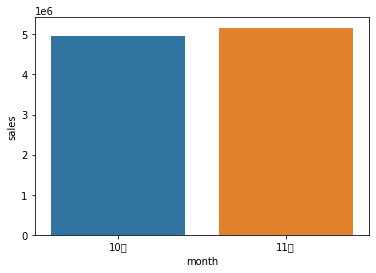

In [14]:
sns.barplot(df_sales["month"], df_sales["sales"])

In [15]:
df_sales_item = df_flg.groupby(["month", "item_id", "item_name"], as_index=False).sum()
df_sales_item

,month,item_id,item_name,receipt_no,user_id,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
0,10月,s_00001,弁当（和風）,18931750886254,97479234248,3567.0,2140200,1783500,0,1783500.0,3567.0,0.0,0.0,0.0,0.0
1,10月,s_00002,弁当（洋風）,14696388294161,76325918362,2769.0,1938300,1522950,0,1522950.0,0.0,2769.0,0.0,0.0,0.0
2,10月,s_00003,おにぎり（うめぼし）,7610913976939,40420591170,2190.0,143400,186420,0,284700.0,0.0,0.0,2190.0,0.0,0.0
3,10月,s_00004,唐揚げ,12780391129072,66380514717,2417.0,385280,602000,0,604250.0,0.0,0.0,0.0,2417.0,0.0
4,10月,s_00005,ミネラルウォーター500ml,26309135785639,139990014127,5083.0,2478500,743550,0,762450.0,0.0,0.0,0.0,0.0,5083.0
5,11月,s_00003,おにぎり（うめぼし）,8274365235032,46026756880,2264.0,155900,202670,0,294320.0,0.0,0.0,2264.0,0.0,0.0
6,11月,s_00004,唐揚げ,17190935975629,88554722568,3245.0,518240,809750,0,811250.0,0.0,0.0,0.0,3245.0,0.0
7,11月,s_00005,ミネラルウォーター500ml,26553335577130,140945092326,5170.0,2501500,750450,0,775500.0,0.0,0.0,0.0,0.0,5170.0
8,11月,s_00006,弁当（和風）,21840290698666,112069526265,4115.0,2057500,1728300,0,1728300.0,4115.0,0.0,0.0,0.0,0.0
9,11月,s_00007,弁当（洋風）,11007718905688,57228567619,2074.0,1762900,1555500,0,1555500.0,0.0,2074.0,0.0,0.0,0.0


/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_name', ylabel='sales'>

/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24403 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21644 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fujiwatarutaiju/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fujiwata

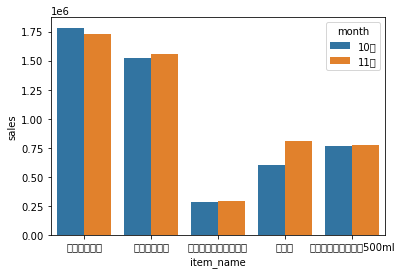

In [16]:
sns.barplot(df_sales_item["item_name"], df_sales_item["sales"], hue=df_sales_item["month"])

In [17]:
df_sales_category = df_flg.groupby(["month", "category_3"]).sum()
df_sales_category

receipt_no       user_id    unit   amount  unit_price  \
month category_3                                                              
10月   おにぎり         7610913976939   40420591170  2190.0   143400      186420   
      弁当          33628139180415  173805152610  6336.0  4078500     3306450   
      揚げ物         12780391129072   66380514717  2417.0   385280      602000   
      水           26309135785639  139990014127  5083.0  2478500      743550   
11月   おにぎり         8274365235032   46026756880  2264.0   155900      202670   
      弁当          32848009604354  169298093884  6189.0  3820400     3283800   
      揚げ物         17190935975629   88554722568  3245.0   518240      809750   
      水           26553335577130  140945092326  5170.0  2501500      750450   

                  shop_flg      sales  弁当（和風）  弁当（洋風）  おにぎり（うめぼし）     唐揚げ  \
month category_3                                                            
10月   おにぎり               0   284700.0     0.0     0.0      2190.0     0.0   
      弁当                 0  3306450.0  3567.0  2769.0         0.0     0.0   
      揚げ物                0   604250.0     0.0     0.0         0.0  2417.0   
      水                  0   762450.0     0.0     0.0         0.0     0.0   
11月   おにぎり               0   294320.0     0.0     0.0      2264.0     0.0   
      弁当                 0  3283800.0  4115.0  2074.0         0.0     0.0   
      揚げ物                0   811250.0     0.0     0.0         0.0  3245.0   
      水                  0   775500.0     0.0     0.0         0.0     0.0   

                  ミネラルウォーター500ml  
month category_3                  
10月   おにぎり                   0.0  
      弁当                     0.0  
      揚げ物                    0.0  
      水                   5083.0  
11月   おにぎり                   0.0  
      弁当                     0.0  
      揚げ物                    0.0  
      水                   5170.0

In [22]:
df_sales_receipt = df_flg.groupby(["month", "receipt_no"], as_index=False).sum()
df_sales_receipt

,month,receipt_no,user_id,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
0,10月,5307465824,69720166,2.0,760,750,0,750.0,1.0,0.0,0.0,1.0,0.0
1,10月,5307465825,45587843,1.0,600,500,0,500.0,1.0,0.0,0.0,0.0,0.0
2,10月,5307465826,0,2.0,800,680,0,680.0,0.0,1.0,1.0,0.0,0.0
3,10月,5307465827,0,1.0,500,150,0,150.0,0.0,0.0,0.0,0.0,1.0
4,10月,5307465828,54852497,1.0,500,150,0,150.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22286,11月,5307488110,141435128,2.0,660,670,0,670.0,1.0,0.0,0.0,1.0,0.0
22287,11月,5307488111,190221660,2.0,660,670,0,670.0,1.0,0.0,0.0,1.0,0.0
22288,11月,5307488112,0,1.0,850,750,0,750.0,0.0,1.0,0.0,0.0,0.0
22289,11月,5307488113,0,2.0,660,670,0,670.0,1.0,0.0,0.0,1.0,0.0


In [23]:
df_1 = df_sales_receipt[(df_sales_receipt["弁当（和風）"] == 1)]
df_1

,month,receipt_no,user_id,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
0,10月,5307465824,69720166,2.0,760,750,0,750.0,1.0,0.0,0.0,1.0,0.0
1,10月,5307465825,45587843,1.0,600,500,0,500.0,1.0,0.0,0.0,0.0,0.0
5,10月,5307465829,23543782,1.0,600,500,0,500.0,1.0,0.0,0.0,0.0,0.0
8,10月,5307465832,65981004,1.0,600,500,0,500.0,1.0,0.0,0.0,0.0,0.0
11,10月,5307465835,0,1.0,600,500,0,500.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22282,11月,5307488106,0,2.0,600,550,0,550.0,1.0,0.0,1.0,0.0,0.0
22285,11月,5307488109,0,2.0,660,670,0,670.0,1.0,0.0,0.0,1.0,0.0
22286,11月,5307488110,141435128,2.0,660,670,0,670.0,1.0,0.0,0.0,1.0,0.0
22287,11月,5307488111,190221660,2.0,660,670,0,670.0,1.0,0.0,0.0,1.0,0.0


In [25]:
df_1_sum = df_1.groupby(["month"]).sum()
df_1_sum

,receipt_no,user_id,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
month,,,,,,,,,,,,
10月,18931750886254,156428240676,5702.0,2811040,2169210,0,2169210.0,3567.0,0.0,372.0,729.0,1034.0
11月,21840290698666,225374546338,8237.0,3088580,2534720,0,2534720.0,4115.0,0.0,834.0,2048.0,1240.0


In [26]:
df_2 = df_sales_receipt[(df_sales_receipt["弁当（洋風）"] == 1)]
df_2

,month,receipt_no,user_id,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
2,10月,5307465826,0,2.0,800,680,0,680.0,0.0,1.0,1.0,0.0,0.0
7,10月,5307465831,29213200,1.0,700,550,0,550.0,0.0,1.0,0.0,0.0,0.0
9,10月,5307465833,0,2.0,800,680,0,680.0,0.0,1.0,1.0,0.0,0.0
15,10月,5307465839,82338382,2.0,1200,700,0,700.0,0.0,1.0,0.0,0.0,1.0
19,10月,5307465843,28315286,1.0,700,550,0,550.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22267,11月,5307488091,69237913,1.0,850,750,0,750.0,0.0,1.0,0.0,0.0,0.0
22275,11月,5307488099,0,1.0,850,750,0,750.0,0.0,1.0,0.0,0.0,0.0
22278,11月,5307488102,0,1.0,850,750,0,750.0,0.0,1.0,0.0,0.0,0.0
22284,11月,5307488108,0,1.0,850,750,0,750.0,0.0,1.0,0.0,0.0,0.0


In [27]:
df_2_sum = df_2.groupby(["month"]).sum()
df_2_sum

,receipt_no,user_id,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
month,,,,,,,,,,,,
10月,14696388294161,124489872041,4547.0,2469280,1834110,0,1834110.0,0.0,2769.0,442.0,533.0,803.0
11月,11007718905688,79771959413,2870.0,2103600,1677300,0,1677300.0,0.0,2074.0,105.0,45.0,646.0


In [73]:
df_user = df_flg.groupby(["month", "user_id"], as_index=False).sum()
df_user = df_user[df_user["user_id"]!=0]
df_user

,month,user_id,receipt_no,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
1,10月,10000222,26537374876,5.0,1960,1530,0,1530.0,2.0,0.0,1.0,1.0,1.0
2,10月,10016128,21229886630,4.0,2060,1500,0,1500.0,0.0,2.0,0.0,1.0,1.0
3,10月,10104687,10614941646,2.0,320,500,0,500.0,0.0,0.0,0.0,2.0,0.0
4,10月,10108710,15922405808,6.0,300,390,0,780.0,0.0,0.0,6.0,0.0,0.0
5,10月,10196807,37152300500,7.0,3560,2730,0,2730.0,0.0,4.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4112,11月,99797573,21229926519,4.0,3050,2400,0,2400.0,0.0,3.0,0.0,0.0,1.0
4113,11月,99846941,10614966778,3.0,320,500,0,750.0,0.0,0.0,0.0,3.0,0.0
4114,11月,99865868,21229930768,4.0,2000,600,0,600.0,0.0,0.0,0.0,0.0,4.0
4115,11月,99901082,15922447915,3.0,480,750,0,750.0,0.0,0.0,0.0,3.0,0.0


In [42]:
df_user_1 = df_user[df_user["弁当（和風）"]!=0]
df_user_1_mean = df_user_1.groupby(["month"]).mean()
df_user_1_mean

,user_id,receipt_no,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
month,,,,,,,,,,,,
10月,5.453256e+07,1.845850e+10,3.477833,1713.891626,1325.738916,0.0,1325.738916,2.184729,0.0,0.233990,0.440887,0.618227
11月,5.453256e+07,2.690998e+10,5.070197,1894.901478,1556.231527,0.0,1556.231527,2.523399,0.0,0.536946,1.251232,0.758621


In [44]:
df_user_1_sum = df_user_1.groupby(["month"]).sum()
df_user_1_sum

,user_id,receipt_no,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
month,,,,,,,,,,,,
10月,44280435699,14988299312087,2824.0,1391680,1076500,0,1076500.0,1774.0,0.0,190.0,358.0,502.0
11月,44280435699,21850905428085,4117.0,1538660,1263660,0,1263660.0,2049.0,0.0,436.0,1016.0,616.0


In [105]:
df_repeat_1 = pd.DataFrame(df_user[["弁当（和風）", "month"]].value_counts())
df_repeat_1

0
弁当（和風） month      
0.0    10月    1275
       11月    1216
2.0    10月     462
       11月     400
3.0    11月     239
       10月     161
1.0    10月     134
       11月      69
4.0    11月      68
       10月      43
5.0    11月      26
       10月      11
6.0    11月       9
7.0    11月       1
6.0    10月       1

In [43]:
df_user_2 = df_user[df_user["弁当（洋風）"]!=0]
df_user_2_mean = df_user_2.groupby(["month"]).mean()
df_user_2_mean

,user_id,receipt_no,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
month,,,,,,,,,,,,
10月,5.473491e+07,2.024245e+10,3.813953,2067.043189,1534.883721,0.0,1534.883721,0.0,2.315615,0.382060,0.441860,0.674419
11月,5.445682e+07,1.429013e+10,2.692449,1966.040516,1568.987109,0.0,1568.987109,0.0,1.937385,0.104972,0.047882,0.602210


In [103]:
df_user_2_sum = df_user_2.groupby(["month"]).sum()
df_user_2_sum

,user_id,receipt_no,unit,amount,unit_price,shop_flg,sales,弁当（和風）,弁当（洋風）,おにぎり（うめぼし）,唐揚げ,ミネラルウォーター500ml
month,,,,,,,,,,,,
10月,32950413474,12185954195022,2296.0,1244360,924000,0,924000.0,0.0,1394.0,230.0,266.0,406.0
11月,29570054150,7759539437699,1462.0,1067560,851960,0,851960.0,0.0,1052.0,57.0,26.0,327.0


In [106]:
df_repeat_2 = pd.DataFrame(df_user[["弁当（洋風）", "month"]].value_counts())
df_repeat_2

0
弁当（洋風） month      
0.0    11月    1485
       10月    1485
2.0    10月     354
       11月     344
3.0    10月     152
1.0    11月     121
3.0    11月      72
1.0    10月      54
4.0    10月      38
       11月       4
5.0    10月       2
8.0    10月       1
6.0    11月       1
       10月       1
5.0    11月       1